<a href="https://colab.research.google.com/github/kriaz100/deep-learning-with-python-notebooks/blob/master/chapter08_intro_to_dl_for_computer_vision_FIXED_i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to deep learning for computer vision
1. First a convolutional network is shown to have a superior performance on MNIST data compared to densely connect networks of chapter 2.
 - To understand why convnets work better on image data, a deep dive is taken into the nuts and bolts of convolutional networks:
     - The convolutional layers and 
     - The MaxPooling layers.
3. A convolutional neural network is trained from a scratch on a dataset of cats and dogs images.
4. Final section shows how to use **pretrained models**, which is a highly effective approach for deep learning on small image datasets.

## Introduction to convnets
- The convnets trained on MNIST handwritten digits dataset are compared the results  obtained using a densly connected network (chapter 2). It will be seen below that <font color='maroon'>even simple convnets have superior performance on image data relative to densely connected network</font>.

- The convnet below is a stack of Conv2D and MaxPooling2D layers.
- Functional API of Keras willl be used to build the model.

**Instantiating a small convnet**

The Convolution and MaxPooling layers will be explained in the next subsection. First look at a full Keras convnet model architecture defined below (we will measure performance after convnet is trained).

- The inputs shape is: 
(image_width x image_height x image_channels)
MNIST hand-written digits data have images of size  (28 x 28). There is only one channel ie. grey. The batch dimension is not included. Hence the input shape is (28x28x1)

- The different types of layers and keywords such as *kernel_size* and *pool_size* will be explained later. But first run the model and look at shapes of the output layers.






In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))  #allowing for only 1 color channel ie black
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Displaying the model's summary**

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

- Notice that we start from input with dimensions (28x28x1). After after each conv2D layer the <font color='blue'>height</font> and <font color='blue'>weight</font> dimensions shrink, and the number of channels grows. The number of channels is specified by the first argument passed to conv2D layer (ie. filters= ).

- after the last conv2D layers the output shape is 3x3x128 -- a 3x3 feature map with 128 channels.
- We want to feed this output into a dense layer. But the dense layers accepts 1D input while the output from last convolutional layer is still a 3D tensor.
- So the 3D output is flattened with layers.Flatten()
- Finally, the flattened input is passed into a dense layer with 10 units, which corresponds to 10-way classification needed for 0-9 digits.

- Training the network is next.

**Training the convnet on MNIST images**

- Becuase this is a 10-way classification, the output layer is softmax, and loss function is sparse_categorical_crossentropy 

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 21s 9ms/step - loss: 0.1523 - accuracy: 0.9523
Epoch 2/5
938/938 [==============================] - 8s 9ms/step - loss: 0.0426 - accuracy: 0.9870
Epoch 3/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0294 - accuracy: 0.9909
Epoch 4/5
938/938 [==============================] - 8s 9ms/step - loss: 0.0227 - accuracy: 0.9929
Epoch 5/5
938/938 [==============================] - 8s 9ms/step - loss: 0.0173 - accuracy: 0.9946


**Evaluating the convnet**

Now that the convnet model is trained, we can evaluate it to measure its performance and compare it to perfromance of model with densely connected layers (chapter 2)

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.0290 - accuracy: 0.9918
Test accuracy: 0.992


The test accuracy is 99.1%, which is higher than 97.8% obtained using densly connected layers. <font color='steelblue'>The error rate (1 - accuracy) is 60% lower!</font> 

### The convolution operation
To understand why the simple convnet works so well compared to densely connected network, let's dive into what the conv2D and MaxPooling layers do

- Dense layers learn global patterns in the input feature spase
- Convolutional layers learn local patterns, e.g in 2D window of size 3x3 in case of MNIST images. They have two properties:
  - <font color='steelblue'>*The patterns they learn are translation invarient*</font>: A pattern learnt at specific location in the picture will be recoganized anywhere.
  - <font color='steelblue'>*They can learn spatial hierachies of patterns*</font>: The first convolutional layer could learn small local pattern such as edges, the second convolutional layer could learn larger patterns made up of features of the first layer.

-  Convolutions operate on 3D tensors, called feature maps. There are two spatial axis -- height and width. There is also depth axis or the channel axis (to represent color channels). With RGB image, this dimension is 3.
- The convolution operation extracts a 3D patch and transforms it to the output feature map (still a 3D tensor). It has height, width and depth (channel axis). However, the channel axis is not limited to RBG ie. dimension 3, it can have arbitray number of channels defined by the number of filters specified for the layer.
- Filters encode specific aspects of input data to represent higher level concepts such as the 'presence of a face'.
- The first convolutional layer (26x26x32) has 32 output channels, each of which is a response to applying one of the filters to 26x26 grid of values
- Convolutions have two key parameters:
  - Size of the patch extracted (3x3 or 5x5). Remember the patch is also 3D tensor.
  - Depth of output feature map (32 in case of first convolution, 64 for the last).
- Convolution invloves sliding 3x3 windows over the entire 3D input feature map. Each of the excratcted 3D patches is <font color='steelblue'>**converted into 1D vector**</font> by taking its tensor product with <font color='steelblue'>**convolutional kernel**</font>, which is <font color='steelblue'>**a matrix of learned weights**</font> that remain the same (ie. are re-used) for each patch. All these 1D vectors are reassembled to produce 3D output map with shape (height, width, output_depth)




#### Understanding border effects and padding
Padding becomes necessary because you cannot center a 3x3 (or 5x5) window around each cell in the feature map. A 5x5 feature map would allow you to center 3x3 window on only 9 of its 25 tiles.

- Padding adds an appropriate number of row and colums to allow centering a convolution window around each tile in the feature map.
- If padding is not done then after the first convolutional layer the output shrinks a little. In the MNIST example, the input was 28x28 and the convolutional window was 3x3, which caused the output to shrink to 26x26 after the first convolutional layer.

#### Understanding convolution strides
- As we slide the convolutional widow (say 3x3) over the input feature map, it is not necessary to center it at every input tile. The centers don't have to be contiguous, which is teh case when stride size is 1. Some tiles may be skipped eg using stride size 2.

- Stride 2 means we are downsampling the feature map by a factor of 2.

- In classification models we rarely use strided convolution, which are more common in other models in next chapter.
- In classification problems, we use Max-Pooling operations.

### The max-pooling operation
- Another way of downsampling is feature space is MaxPooling. This done by extracting a window and outputing max value of each channel. Unlike the convolutional kernel, this does not involve learned weights. Rather the max is a hardcoded tensor operation.
- The window size in maxPooling is 2x2.
- The stride in maxPooling is 2, which downsamples the input features. Note that after the first MaxPooling2D layer the output size halved to 13x13 (input size was 26x26). 


**An incorrectly structured convnet missing its max-pooling layers**

In [ ]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

## Training a convnet from scratch on a small dataset
Not having enough data is a common situation in computer vision work in professional settings.
- Naive convnets trained on small data sets may be prone to overfitting. Accuracy is only 70% on dogs & cats dataset (2500 dogs & 2500 cats).
- <font color='steelblue'>**Data augmentation**</font> is a strategy used for mitigating overfitting in computer vision. With this strategy used on dogs and  cats data, the accuracy improved to 80-85%
-In the next section two more strategies are presented that improve performance to 98.5%
  - Feature extraction with a pretrained model
  - Fine-tuning a pretrained model


### The relevance of deep learning for small-data problems
Convnets learn *local, translation-invariant features*, therefore, they are highly efficient o perceptual data. Training a convnet from scratch on very small image data would yield reasonable results. 

### Downloading the data
<font color='red'>**Before running the cell below, read the instructions in section 8.2.2 of the Chollet book**</font>. You need to use Kaggle API to download the dataset to Google colab. Read instructions in the **Sidebar box**.

Before running the code cell below: 
1. go to kaggle website
2. navigate to your account page. Scroll down to API section on this page
3. Click on "Create a new API token" tab. This will download kaggle.jason file in your downloads folder
4. Run the cell below. It will ask you to **Choose Files**. Select the kaggle.jason file  


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kriaz100","key":"41dcf8a6ce23e33318686496f28ea1a8"}'}

The cell below will make a directory ~/.kaggle, upload the kaggle.jason file, and perform chmod as a security precaution.

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

The following cell will download the dataset dogs-vs-cats

In [3]:
!kaggle competitions download -c dogs-vs-cats # can use --force to force a re-download replacing the existing copy

 98% 792M/812M [00:04<00:00, 181MB/s]
100% 812M/812M [00:04<00:00, 179MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

In [6]:
!unzip -qq test1.zip

In [7]:
!rm -rf cats_vs_dogs_small/

In [8]:
!rm -rf train.zip test1.zip sampleSubmission.csv

**Copying images to training, validation, and test directories**

We want to have three directories(**train, validation, test**) with each having subdirectories (cat, dog):

**Train**

/cats_vs_dogs_small/train/cat  (1000 cat images)

/cats_vs_dogs_small/train/dog(1000 dog images


**Validation**

/cats_vs_dogs_small/validation/cat (500 cat images)

/cats_vs_dogs_small/validation/dog (500 dog images)


**test**

/cats_vs_dogs_small/test/cat (1000 cat images)

/cats_vs_dogs_small/test/dog  (1000 dog images)


The following are imported: os, shutil, pathlib.
The code below is annotated as follows (#1,#2, ...)

1. Path to directory where the original data was uncompressed
2. Directory where smaller datasets will be stored
3. Utility function to copy cat(respecively dog) images from index *start_index* to index *end_index* (e.g 1000 to 1500) to the subdirectory new_base_dir/{subset_name)/cat (respectively dog). The "subset_name" will be either "train", "validation", or "test".
4. create validation immages with next 500 images of each category
5. create test subset with gthe next 1000 images of eact category

In [9]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")                 #1
new_base_dir = pathlib.Path("cats_vs_dogs_small")    #2

def make_subset(subset_name, start_index, end_index):        #3
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)            #4
make_subset("validation", start_index=1000, end_index=1500)    #5
make_subset("test", start_index=1500, end_index=2500)          #6

In [10]:
ls /content

cats_vs_dogs_small/  kaggle.json   test1/
dogs-vs-cats.zip     sample_data/  train/


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Configuring the model for training**

In [13]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing
The images are in the form of JPEG files. We need to build a <font color='steelblue'>**data pipline**</font> to convert the JPEG images to RBG based floating point tenrors, which can be fed into the deep learning model.

The data pipeline can be built with <font color='steelblue'>tensorflow utility **image_dataset_from_directory**</font>

The utility performs the following tasks:
1. Read the picture files
2. Decode the JPEG content to RGB grids of pixels
3. Convert these into floating-point tensors
4. Resize them into shared size (we'll use 180x180)
5. Pack them into batches (we'll use batches of 32 images).

Calling the utility *image_from_directory(directory)*
 will create and return <font color='steelblue'>tf.data.Dataset object</font>.

<font color='blue'>See book SIDEBAR: Understanding Tensorflow Dataset objects</font>. See below.

**Using `image_dataset_from_directory` to read images**

In [15]:
# TensorFlow utility image_from_directory()
# --converts images to tensors (RGB) 

from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.




---
<font color='steelblue'>**SIDEBAR: Understanding TensorFlow Dataset objects**</font>


---
It is demonstrated below:
- How to create a Dataset object from a numpy array 
- Dataset object is iterable
- The batch() method called on Dataset object can be used to batch data 
- The map() method called on Dataset ofbject can be used to perform arbitrary transformations of each element of Dataset. Moreover, this method used with shape() method can be used to reshape the Datset.  


In [16]:
# Creating a dataset object from numpy array
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [17]:
# dataset object is an iterable
#   This is demonstarted by iterating over it to print shape
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [18]:
# batch() method can use used to batch data
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [19]:
# map() a callable method can be used to apply arbitrary transformation
#       on each element of the dataset
#       Here map() is used along with reshape() to reshape data

reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

The Dataset object has batches of size 180x180x3. Original image size was 180x180, and there are RGB channels. Batch size is 32. So we have tensors of shape (32x180x180x3). 

The labels shape is (32, ) because there are 32 labels when the batch size is 32.

In [20]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)




---


<font color='steelblue'>**END of SIDEBAR**</font>


---




**Fitting the model using a `Dataset`**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 11s 124ms/step - loss: 0.7397 - accuracy: 0.5025 - val_loss: 0.7006 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 7s 111ms/step - loss: 0.7052 - accuracy: 0.5370 - val_loss: 0.7023 - val_accuracy: 0.5050
Epoch 3/30
63/63 [==============================] - 7s 112ms/step - loss: 0.6921 - accuracy: 0.5865 - val_loss: 0.6777 - val_accuracy: 0.5700
Epoch 4/30
63/63 [==============================] - 7s 113ms/step - loss: 0.6717 - accuracy: 0.6320 - val_loss: 0.6408 - val_accuracy: 0.6260
Epoch 5/30
63/63 [==============================] - 7s 111ms/step - loss: 0.6279 - accuracy: 0.6625 - val_loss: 0.6503 - val_accuracy: 0.6060
Epoch 6/30
63/63 [==============================] - 8s 114ms/step - loss: 0.5796 - accuracy: 0.6955 - val_loss: 0.6454 - val_accuracy: 0.6530
Epoch 7/30
63/63 [==============================] - 7s 113ms/step - loss: 0.5257 - accuracy: 0.7410 - val_loss: 0.5822 - val_accuracy: 0.6970
Epoch

**Displaying curves of loss and accuracy during training**

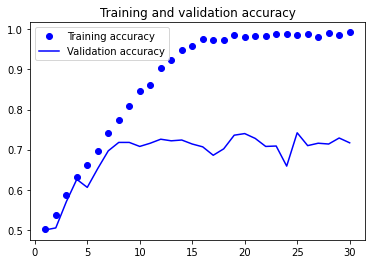

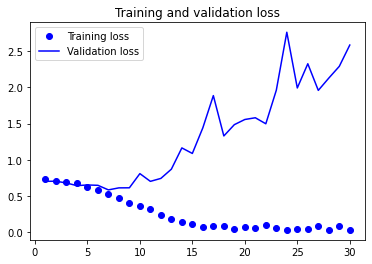

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 52ms/step - loss: 0.5731 - accuracy: 0.7025
Test accuracy: 0.702


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

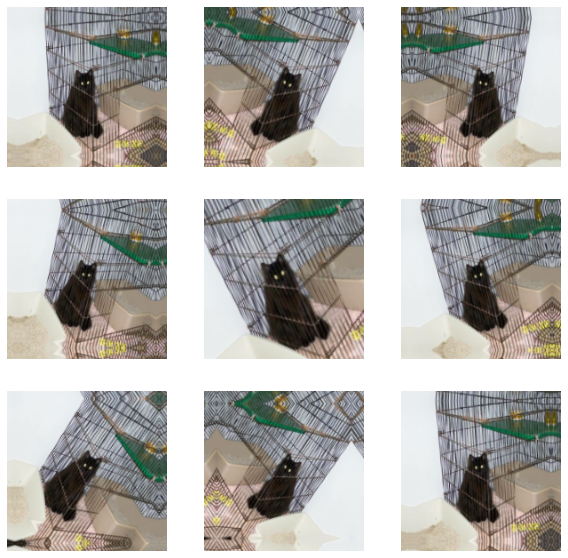

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 10s 122ms/step - loss: 0.7767 - accuracy: 0.5425 - val_loss: 0.7356 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 8s 120ms/step - loss: 0.7041 - accuracy: 0.5395 - val_loss: 0.6816 - val_accuracy: 0.5240
Epoch 3/100
63/63 [==============================] - 8s 118ms/step - loss: 0.6975 - accuracy: 0.5785 - val_loss: 0.6782 - val_accuracy: 0.5850
Epoch 4/100
63/63 [==============================] - 8s 122ms/step - loss: 0.6690 - accuracy: 0.6145 - val_loss: 0.6459 - val_accuracy: 0.6210
Epoch 5/100
63/63 [==============================] - 8s 119ms/step - loss: 0.6486 - accuracy: 0.6490 - val_loss: 0.6433 - val_accuracy: 0.6290
Epoch 6/100
10/63 [===>..........................] - ETA: 4s - loss: 0.6162 - accuracy: 0.6625

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary()

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

**Plotting the results**

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

### Fine-tuning a pretrained model

In [ ]:
conv_base.summary()

**Freezing all layers until the fourth from the last**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

## Summary